Tasks:

* Get early attention blocks
* Use those blocks to predict the next token
* For loop to iterate over all attention block predictions
* Time how long it takes for each prediction
* Add some kind of benchmark; plot layer vs accuracy

### Setup & loading model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [2]:
model = AutoModelForCausalLM.from_pretrained("gpt2-medium", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")

In [3]:
def predict_next_token(text, model, tokenizer):
    input_ids = tokenizer.encode(text, return_tensors="pt")

    with torch.no_grad():
        output = model(input_ids=input_ids)

    logits = output.logits[0, -1, :]
    next_token_id = torch.argmax(logits).item()
    next_token = tokenizer.decode(next_token_id)

    return next_token

In [4]:
text = "Once upon a time"
next_token = predict_next_token(text, model, tokenizer)
print("Next token prediction:", next_token)

Next token prediction: ,


### Get early attention blocks

In [5]:
def get_hiddenstates_attn(text, model, tokenizer):
  input_ids = tokenizer.encode(text, return_tensors="pt")
  with torch.no_grad():
    output = model(input_ids=input_ids)
  hidden_states = output.hidden_states
  attentions = output.attentions
  return hidden_states, attentions

In [6]:
hidden, attn = get_hiddenstates_attn(text, model, tokenizer)

### Use blocks to predict next token


In [7]:
# this always returns none; I am not sure why
def get_next_token_from_hidden(text, hidden_states, attentions, layer):
  logits = model.lm_head(hidden_states[layer])
  next_token_logits = logits[:, -1, :]
  probabilities = F.softmax(next_token_logits, dim=-1)
  predicted_token_id = probabilities.argmax(dim=-1)  # Take max prediction
  # Ariel: Where is the temperature added?
  predicted_token = tokenizer.decode(predicted_token_id.tolist())
  return predicted_token

In [8]:
# Ariel: We are making a prediction from hidden state i? Iterating over the blocks
# Ariel: So indeed it seems later blocks predict something different
for i in range(len(hidden)):
  print(get_next_token_from_hidden(text, hidden, attn, i))

 time
abwe
 Sponsor
mi
 lapse
 lapse
 lapse
 lapse
 CI
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,


### Predicting $k$ next tokens

In [9]:
def full_model_prediction(model, input_text, num_tokens_to_generate=20):

    # get the input ids from the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    for _ in range(num_tokens_to_generate):
        # Get model outputs
        outputs = model(input_ids)
        logits = outputs.logits

        # Only use the logits from the last token position
        next_token_logits = logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)
        # print(next_token_logits)

        # Append the predicted token ID to the input sequence
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

    # Decode the input IDs to a string
    generated_text = tokenizer.decode(input_ids[0])

    return generated_text

In [10]:
input_text = "Once upon a time"
num_tokens_to_generate = 20
print("Generated text: ", full_model_prediction(model, input_text, num_tokens_to_generate))

Generated text:  Once upon a time, there was a man who lived in a village called Krakow. He was a very good


In [31]:
from matplotlib import pyplot as plt

def early_prediction(model, input_text, num_tokens_to_generate=20, exit_layer=5):
    def get_hiddenstates_attn(input_ids, model, tokenizer):
        with torch.no_grad():
            output = model(input_ids=input_ids)
        hidden_states = output.hidden_states
        attentions = output.attentions
        return hidden_states, attentions

    token_probabilities = []
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    for _ in range(num_tokens_to_generate):
        # outputs = model(input_ids)
        hidden_states, attns = get_hiddenstates_attn(input_ids, model, tokenizer)

        # if apply_layer_norm:
        if exit_layer != len(hidden_states) - 1:
            # print("yes for ", str(exit_layer))
            ln_f = nn.LayerNorm(model.config.n_embd, eps=model.config.layer_norm_epsilon)
            layer_norm = ln_f(hidden_states[exit_layer])
            logits = model.lm_head(layer_norm)
        else:
            # print("no layernorm or lm_head for ", str(exit_layer))
            # logits = model.lm_head(hidden_states[exit_layer])
            logits = model.lm_head(hidden_states[exit_layer])

        # Only use the logits from the last token position
        next_token_logits = logits[:, -1, :]
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)
        
        k = 15
        top_k_tokens = torch.topk(next_token_logits, k, dim=-1)
        top_k_probabilities = F.softmax(top_k_tokens.values, dim=-1)
        
        plt.figure()
        plt.plot(top_k_probabilities[0].tolist())
        plt.title('Top-15 probabilities for early exit layer ' + str(exit_layer))
        
        # plt.legend()

        # print(next_token_logits)

        # Append the predicted token ID to the input sequence
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

        # get the probabilities
        probabilities = F.softmax(next_token_logits, dim=-1)
        top_proba = probabilities[0][next_token_id].item()
        # top_proba = next_token_logits[0][next_token_id].item()
        token_probabilities.append(top_proba)

    # print(input_ids)
    generated_text = tokenizer.decode(input_ids[0])

    return generated_text, token_probabilities

Generated text:  Once upon a time, there was a man
Probabilities:  [0.6449872851371765, 0.1095908135175705, 0.7458513975143433, 0.671569287776947, 0.0749153271317482]


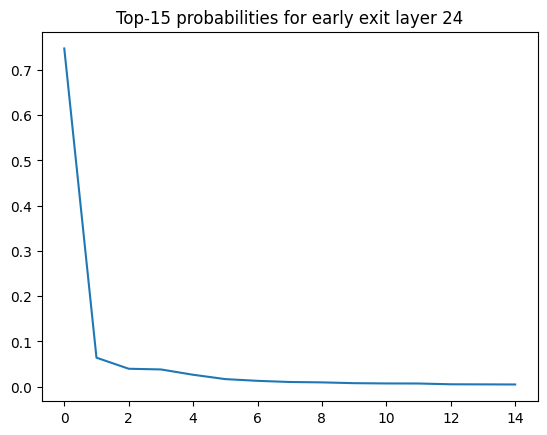

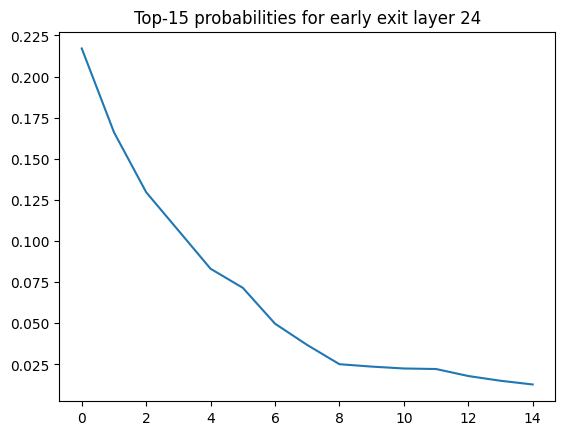

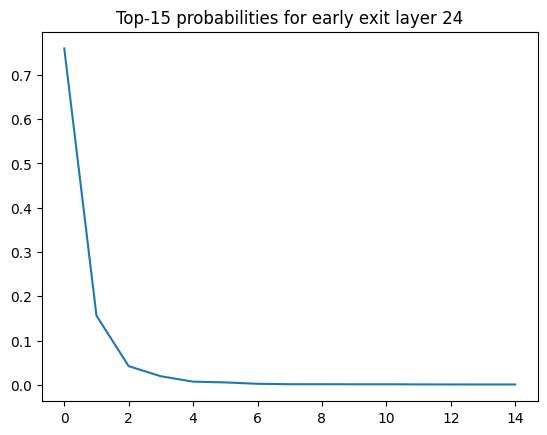

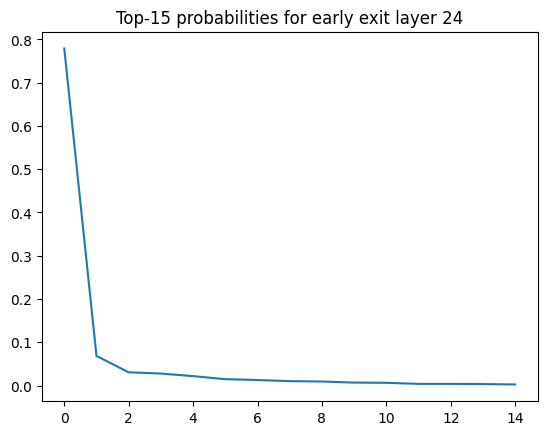

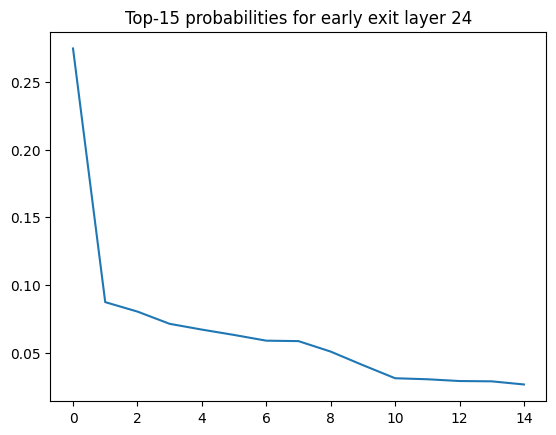

In [32]:
input_text = "Once upon a time"
num_tokens_to_generate = 5
generated_text, token_probabilities = early_prediction(model, input_text, num_tokens_to_generate, exit_layer=24)
print("Generated text: ", generated_text)
print("Probabilities: ", str(token_probabilities))

#### Let's compare the prediction from the different early exit blocks

 80%|████████  | 20/25 [00:03<00:00,  6.43it/s]/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_1839/3549752194.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|██████████| 25/25 [00:03<00:00,  6.26it/s]


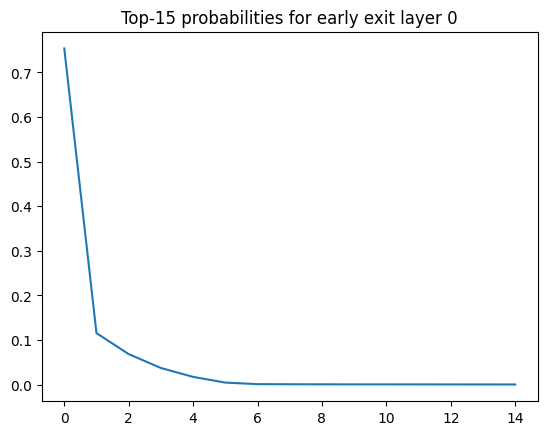

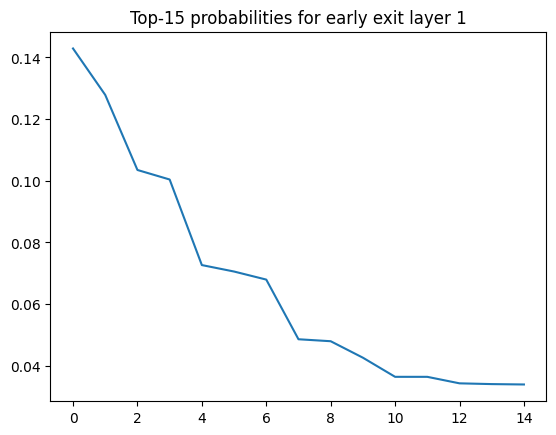

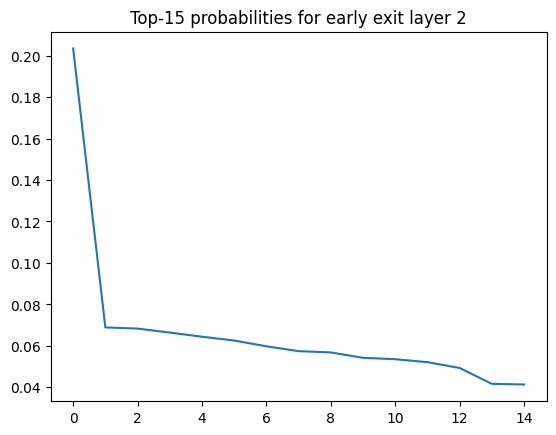

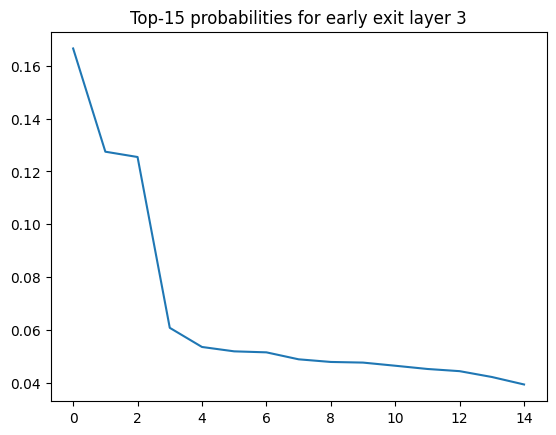

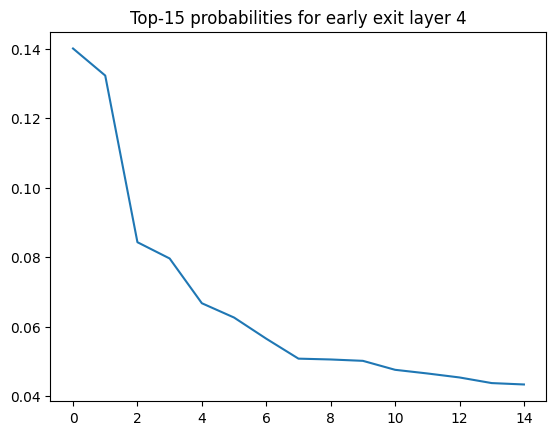

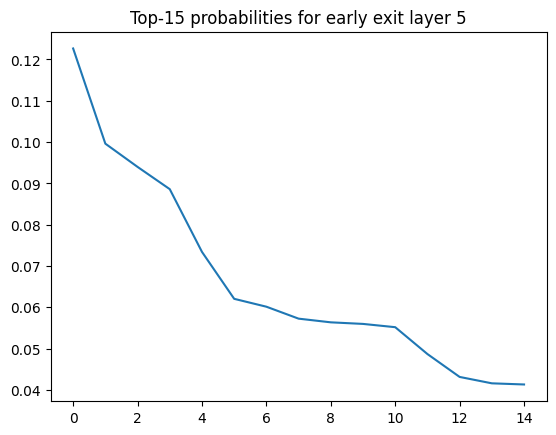

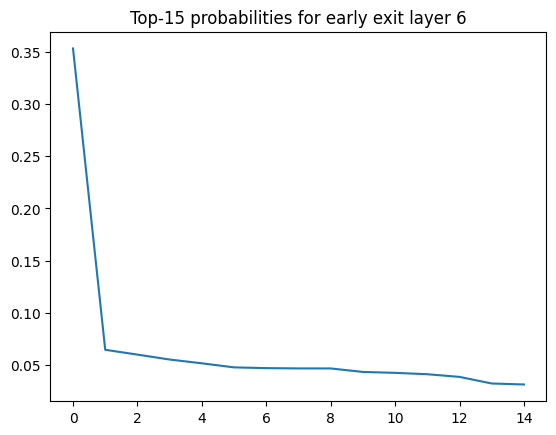

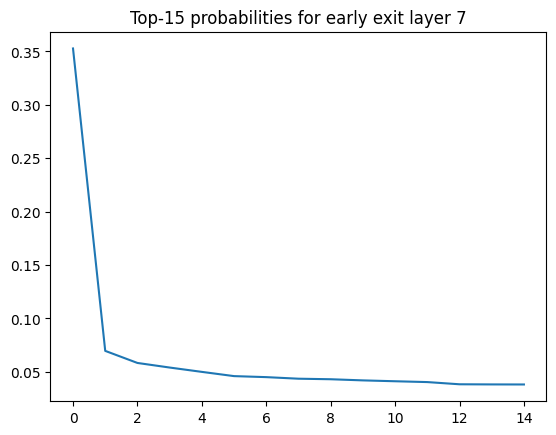

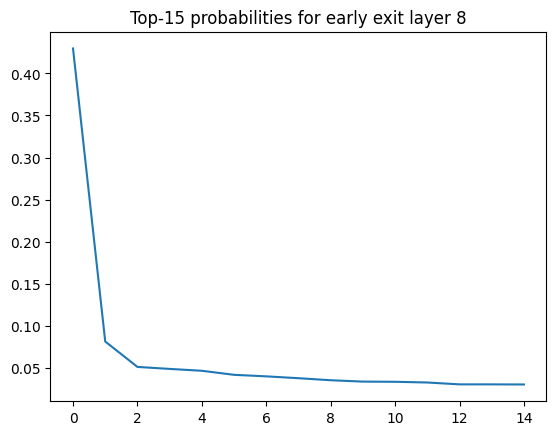

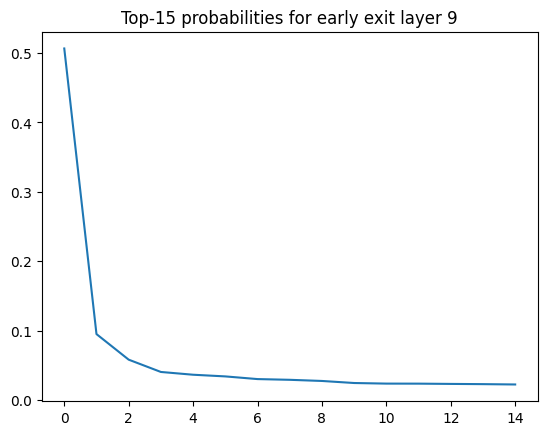

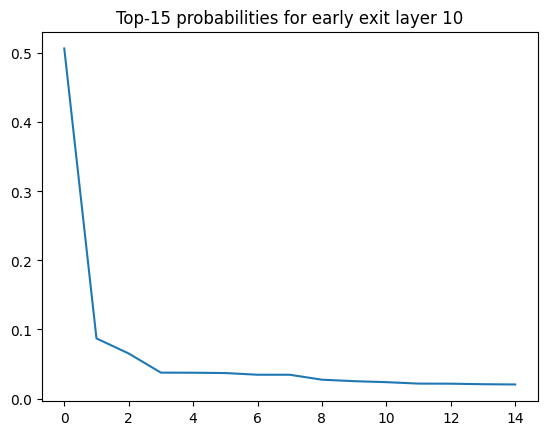

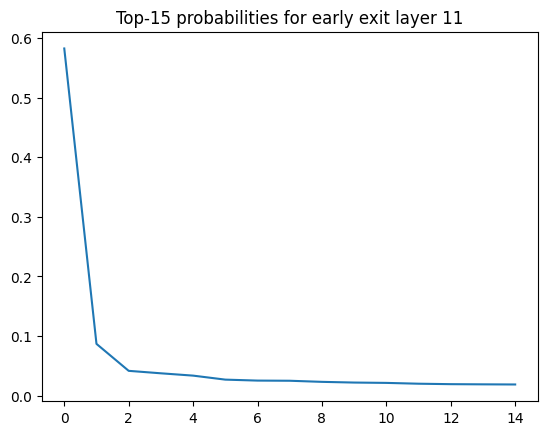

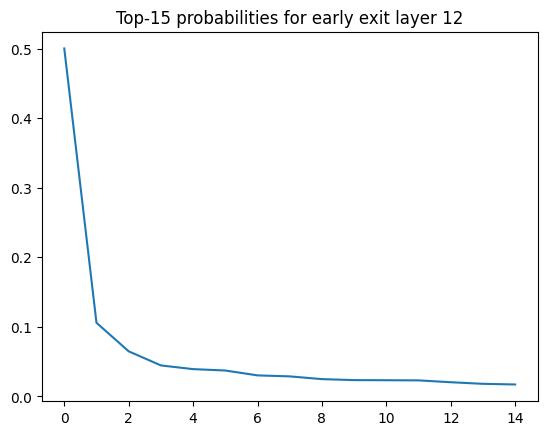

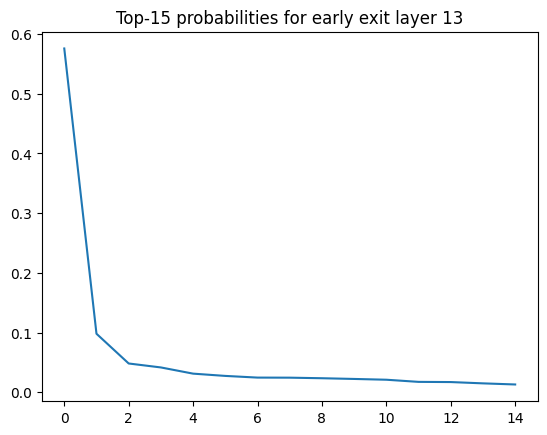

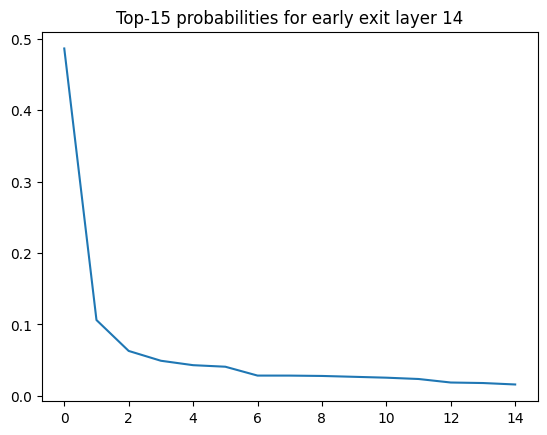

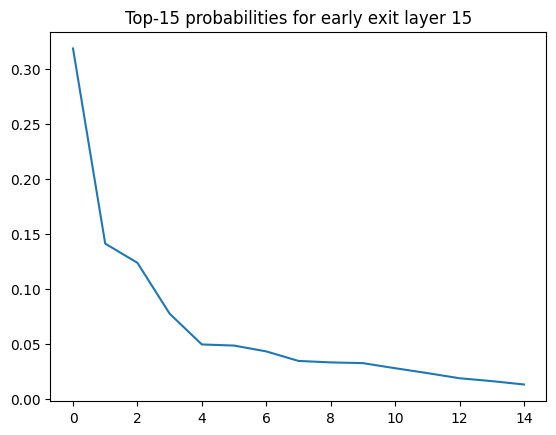

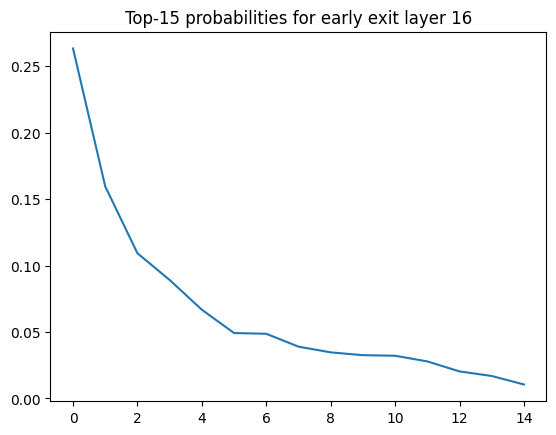

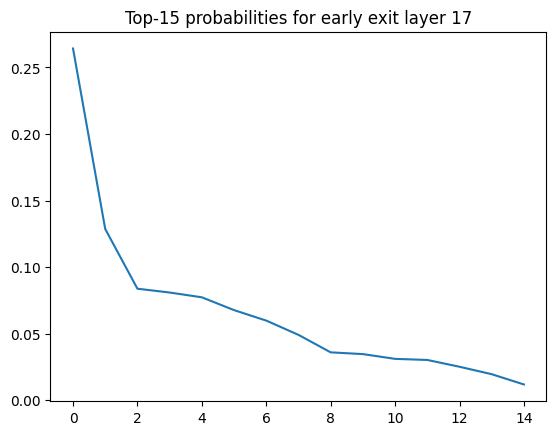

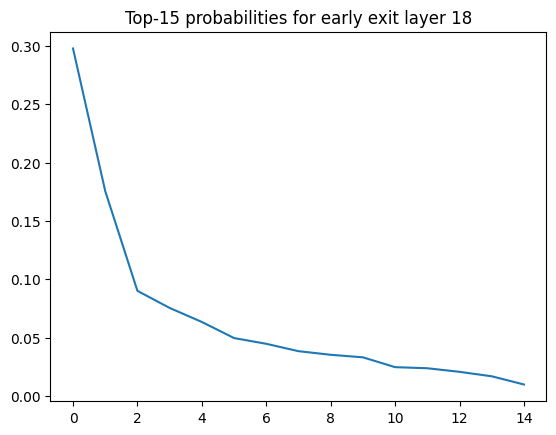

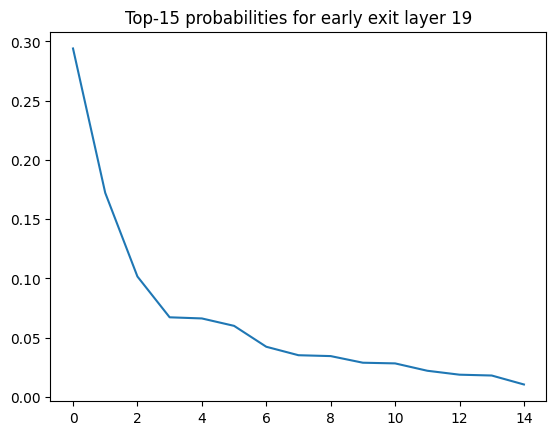

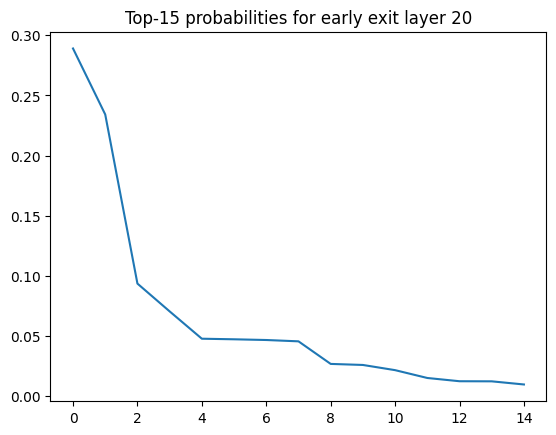

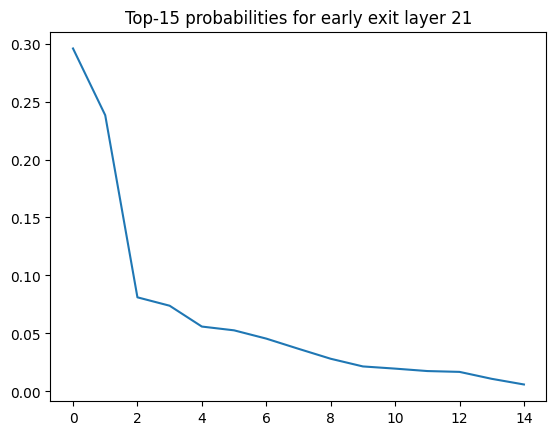

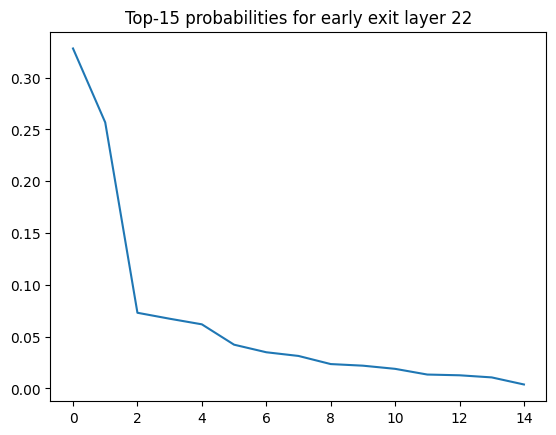

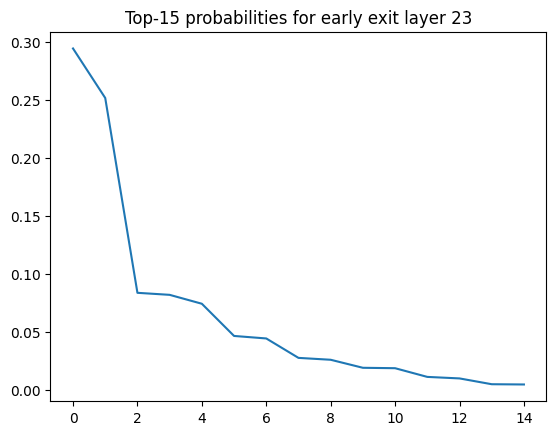

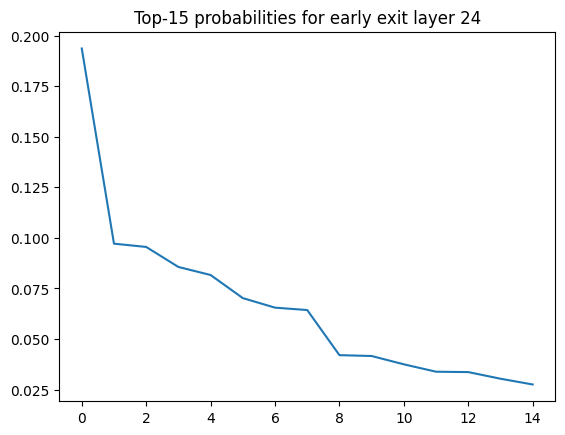

In [33]:
input_text = "Today I"
num_tokens_to_generate = 1
gens = []
probas = []
for exit_layer in tqdm(range(25)):  # Loop over the layers
    generated_text, token_probabilities = early_prediction(model, input_text, num_tokens_to_generate, exit_layer)
    gens.append(generated_text)
    probas.append(token_probabilities)

In [17]:
# printing out the different generations
for layer, gen in enumerate(gens):
    print("Generated text for layer ", str(layer), ": ")
    print("\t", gen)
    # print("\tAverage probability: ", str(sum(probas[int(layer)])/len(probas[int(layer)])))

Generated text for layer  0 : 
	 Today I I
Generated text for layer  1 : 
	 Today Imi
Generated text for layer  2 : 
	 Today Imi
Generated text for layer  3 : 
	 Today Imi
Generated text for layer  4 : 
	 Today Imi
Generated text for layer  5 : 
	 Today I am
Generated text for layer  6 : 
	 Today I am
Generated text for layer  7 : 
	 Today I am
Generated text for layer  8 : 
	 Today I am
Generated text for layer  9 : 
	 Today I am
Generated text for layer  10 : 
	 Today I am
Generated text for layer  11 : 
	 Today I am
Generated text for layer  12 : 
	 Today I am
Generated text for layer  13 : 
	 Today I am
Generated text for layer  14 : 
	 Today I am
Generated text for layer  15 : 
	 Today I am
Generated text for layer  16 : 
	 Today I am
Generated text for layer  17 : 
	 Today I,
Generated text for layer  18 : 
	 Today I,
Generated text for layer  19 : 
	 Today I,
Generated text for layer  20 : 
	 Today I,
Generated text for layer  21 : 
	 Today I,
Generated text for layer  22 : 
	 T

In [18]:
average_probas = [sum(layer)/len(layer) for layer in probas]
first_token_probas = [layer[0] for layer in probas]

In [19]:
probas

[[0.7525216341018677],
 [0.008616272360086441],
 [0.010108577087521553],
 [0.006772140506654978],
 [0.005841453559696674],
 [0.0061225262470543385],
 [0.020087625831365585],
 [0.02021527662873268],
 [0.035666611045598984],
 [0.06762652844190598],
 [0.09318627417087555],
 [0.16531310975551605],
 [0.19011403620243073],
 [0.29350149631500244],
 [0.2875578999519348],
 [0.21857352554798126],
 [0.19758763909339905],
 [0.2155454307794571],
 [0.2587285339832306],
 [0.26028168201446533],
 [0.2641880214214325],
 [0.2745525538921356],
 [0.30867117643356323],
 [0.2735569179058075],
 [0.10680204629898071]]

In [20]:
first_token_probas

[0.7525216341018677,
 0.008616272360086441,
 0.010108577087521553,
 0.006772140506654978,
 0.005841453559696674,
 0.0061225262470543385,
 0.020087625831365585,
 0.02021527662873268,
 0.035666611045598984,
 0.06762652844190598,
 0.09318627417087555,
 0.16531310975551605,
 0.19011403620243073,
 0.29350149631500244,
 0.2875578999519348,
 0.21857352554798126,
 0.19758763909339905,
 0.2155454307794571,
 0.2587285339832306,
 0.26028168201446533,
 0.2641880214214325,
 0.2745525538921356,
 0.30867117643356323,
 0.2735569179058075,
 0.10680204629898071]

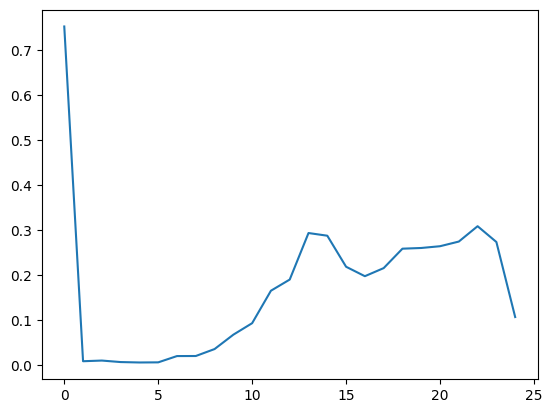

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(first_token_probas)

In [ ]:
model.Model.summary()

AttributeError: 'GPT2LMHeadModel' object has no attribute 'Model'

In [ ]:
from transformers import GPT2LMHeadModel

In [ ]:
model.config

In [ ]:
print(model)

In [ ]:
dir(model)

### Prediction time

In [ ]:
# code

### Benchmark & plotting

In [ ]:
# code